In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pandas as pd

In [2]:
import measures as nolds

In [3]:
def var(u_e):
    return np.var(u_e)

def freq(u_e):
    ind = argrelextrema(np.array(u_e), np.greater)
#     print(ind)
    diffs = np.diff(argrelextrema(np.array(u_e), np.greater))
#     print(diffs)
    n = int(len(diffs)/2)
    sub_ind = diffs[n-1:n+1]
    abso = np.absolute(sub_ind)
#   print(mean(abso), "here")
    #print(1/(0.01*mean(abso)))
    freq = 1/np.mean(abso)
    return 1/(0.01*np.mean(abso))
#TIME STEP IS SIZE 0.01

#print(freq(G[:,0]),freq(G[:,1]))

In [4]:
#FINAL ONE
#param
freq_x = []
freq_y = []
var_x =[]
z_list = list(np.arange(-3,0,0.1))
for z in z_list:
    #print(z)
    alpha = 3
    a = 0.7
    b = 0.8
    omega_sq = 1
    #model -> G[x,y]

    def model(G,t):
        return np.array([ alpha*(G[1] + G[0] - ((G[0]**3)/3) + z), -(1/alpha)*(G[0] - a + (b*G[1]) )])

    t = np.linspace(0, 100,  10000)              # time step
    G0 = np.array([0, 0])                     # initials conditions
    G = odeint(model, G0, t)

#     plt.show()
    freq_x.append(freq(G[:,0]))
    var_x.append(var(G[5000:,0]))
    freq_y.append(freq(G[:,1]))



/scinet/gpc/Applications/anaconda3/4.2.0_hub/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [5]:
#fixing the frequencies

freq_new = []

for i in range(len(z_list)):
    if var_x[i] < 0.1:
        freq_new.append(0)
    else:
        freq_new.append(freq_x[i])


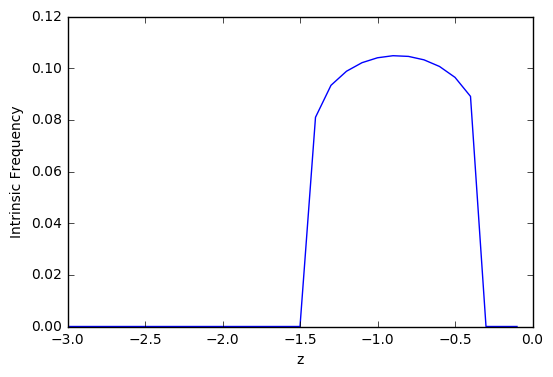

In [6]:
# #FINAL PLOT
plt.plot(z_list, freq_new)
plt.xlabel("z")
plt.ylabel("Intrinsic Frequency")
plt.show()
# freq_new

In [7]:
#GETTING THE VALUES FOR K1 AND K2
table = [z_list, freq_new]


k1_col = []
k1freq = []
k2_col = []
k2freq = []
perc_diff = []

k_freq = np.transpose(table)[16:-2]
k_freq
num_k_vals = np.shape(k_freq)[0] #num of rows

#k_freq is a 12x2 array with k values in first column and the corresponding freq in second, it contains the subset of k that 
#actually result in oscillations

for i in range(num_k_vals):
    for j in range(i,num_k_vals):
        #appending the k1 value from the ith row in the first column of k_freq
        k1_col.append(k_freq[:,0][i])
        #appending the k1 frequency from the ith row in the second column of k_freq
        k1freq.append(k_freq[:,1][i])
        k2_col.append(k_freq[:,0][j])
        k2freq.append(k_freq[:,1][j])
        
        #calculating the percent difference in frequencies
        perc = (1- (min(k_freq[j,1],k_freq[i,1])/max(k_freq[j,1],k_freq[i,1])))*100
        perc_diff.append(perc)

In [8]:
#converting to dataframe to see what data looks like
d = {'k1': k1_col, 'freq1': k1freq, 'k2': k2_col, 'freq2': k2freq, 'perc_diff': perc_diff}
df = pd.DataFrame(data=d)
#df

In [15]:
#FINAL PERCENT DIFFERENCE COLUMN
df_sorted = df.sort_values('perc_diff')
#df_single = df_sorted.drop_duplicates('perc_diff')
#df_final= df_s.drop(77)
#df_final
df_sorted
df_numpy = df_sorted.values
final_df_numpy = df_numpy[0:-12]

In [16]:
#PART 2, PLOTTING COUPLED OSCI
#The following code defines the "right hand side" of the system of equations (also known as a vector field). 

from scipy.integrate import odeint
import matplotlib.pyplot as plt

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [alpha, k1, k2, c, b,a]
    """
    x1, y1, x2, y2 = w
    alpha, k1, k2, c, b, a = p

    # Create f = (x1',y1',x2',y2'):
    f = [ alpha*(y1 + x1 - ((x1**3)/3) + k1+ c*x2),
         -(1/alpha)*( x1- a + (b*y1)), 
         alpha*(y2 + x2 - ((x2**3)/3) + k2+ c*x1),
        -(1/alpha)*( x2- a + (b*y2))]
    
    return f

In [18]:
# Use ODEINT to solve the differential equations defined by the vector field
solution_list = [] #from this we can get time series for everything

freq_listx1 = []
freq_listx2 = []

var_listx1 = []
var_listx2 = []

x1ts_list = []
x2ts_list = []

c_list = np.linspace(0,1,20)

#for each row in final_df_numpy set the k1 and k2
for i in range(np.shape(final_df_numpy)[0]):
    k1 = final_df_numpy[i,2]
    k2 = final_df_numpy[i,3]
    
    for c in c_list:

        # Parameter values
        alpha = 3
        a = 0.7
        b = 0.8

        # Initial conditions
        x1 = 0.0
        y1 = 0.0
        x2 = 0.0
        y2 = 0.0

        # Pack up the parameters and initial conditions:
        p = [alpha, k1, k2, c, b, a]
        w0 = [x1, y1, x2, y2]
        t = np.linspace(0, 100,  10000)              # time step

        #Call the ODE solver.
        wsol = odeint(vectorfield, w0, t, args=(p,))
        
        x1= wsol[:,0]
        x2= wsol[:,2]
        

        solution_list.append(wsol)
        
        freq_listx1.append(freq(x1))
        freq_listx2.append(freq(x2))
        
        var_listx2.append(var(x2))
        var_listx1.append(var(x1))

        x1ts_list.append(x1)
        x2ts_list.append(x2)

np.save('x1ts_listall.npy', x1ts_list)
np.save('x2ts_listall.npy',x2ts_list)

/scinet/gpc/Applications/anaconda3/4.2.0_hub/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [37]:
np.load('x1ts_list20.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'x1ts_list20.npy'

In [23]:
perc_diff_list = np.arange(66)

In [24]:
#data to use for the rest of the proj
# x axis - c_list


print(len(c_list), len(perc_diff_list))
print(num_runs, len(x1ts_list), len(c_list)*len(perc_diff_list))

20 66
1320 1320 1320


In [21]:
#MAXIMUM LYAPUNOV EXPONENT
rwalk = np.cumsum(np.random.random(1000))
h = nolds.dfa(rwalk)
h

2.0351508123487569

In [ ]:
max_lyap_x1 = []
max_lyap_x2 = []
# posx1_ind = []
# posx2_ind = []

for i in range(num_runs):
    lx1 = nolds.lyap_r(x1ts_list[i])
    lx2 = nolds.lyap_r(x2ts_list[i])
    
    max_lyap_x1.append(lx1)
    max_lyap_x2.append(lx2)
    
#     if lx1 > 0:
#         posx1_ind.append(i)
#     if lx2 > 0:
#         posx2_ind.append(i)

np.save('max_lyap_x1_all.npy', max_lyap_x1)
np.save('max_lyap_x2_all.npy', max_lyap_x2)

/bg01/homescinet/l/lfefebvr/noorir/measures.py:248: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/bg01/homescinet/l/lfefebvr/noorir/measures.py:248: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/bg01/homescinet/l/lfefebvr/noorir/measures.py:248: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/bg01/homescinet/l/lfefebvr/noorir/measures.py:278: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 813
  warnings.warn(msg.format(lag), RuntimeWarning)
/bg01/homescinet/l/lfefebvr/noorir/measures.py:248: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/bg01/homescinet/l/lfefebvr/noorir/measures.py:248: RuntimeWarning: signal has

layp x1


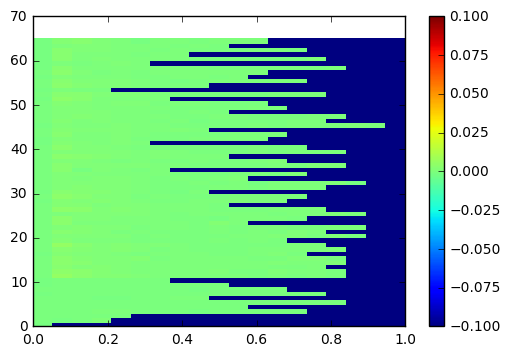

layp x2


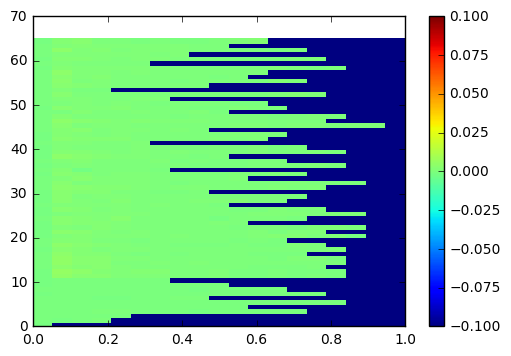

In [27]:
#PLOTTING LYAP FOR X1
print("layp x1")
x=c_list
y=perc_diff_list
z=np.array(max_lyap_x1)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

#phase_list is arranged so that its a sequence of 15 groups, each of 50 values (for diff c), since numpy is row-major, it'll
#fill array by rows, so you want there to be 15 rows, and 50 columns

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

#PLOTTING LYAP FOR X2
print("layp x2")

x=c_list
y=perc_diff_list
z=np.array(max_lyap_x2)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

#phase_list is arranged so that its a sequence of 15 groups, each of 50 values (for diff c), since numpy is row-major, it'll
#fill array by rows, so you want there to be 15 rows, and 50 columns

Z= z.reshape(len(y),len(x))

# plt.pcolormesh(X,Y,Z,edgecolor='k')
plt.pcolormesh(X,Y,Z)
plt.colorbar()

plt.show()

In [35]:
np.shape(Z)

(66, 20)

In [34]:
for i in range(66):
    print(final_df_numpy[i,2], final_df_numpy[i,3])

-1.4 -1.4
-0.4 -0.4
-1.3 -1.3
-1.0 -1.0
-1.1 -1.1
-0.9 -0.9
-1.2 -1.2
-0.8 -0.8
-0.7 -0.7
-0.6 -0.6
-0.5 -0.5
-0.9 -0.8
-1.0 -0.8
-1.0 -0.9
-1.0 -0.7
-1.1 -0.7
-0.8 -0.7
-1.1 -0.6
-0.9 -0.7
-1.1 -1.0
-1.2 -0.6
-1.1 -0.8
-1.2 -0.5
-0.7 -0.6
-1.1 -0.9
-1.3 -0.5
-1.0 -0.6
-1.2 -1.1
-0.8 -0.6
-0.9 -0.6
-0.6 -0.5
-1.2 -0.7
-1.3 -0.4
-1.2 -1.0
-1.2 -0.8
-1.3 -1.2
-1.1 -0.5
-1.2 -0.9
-0.7 -0.5
-1.3 -0.6
-1.0 -0.5
-0.5 -0.4
-0.8 -0.5
-0.9 -0.5
-1.3 -1.1
-1.4 -0.4
-1.3 -0.7
-1.2 -0.4
-1.3 -1.0
-1.3 -0.8
-1.3 -0.9
-0.6 -0.4
-1.1 -0.4
-1.4 -1.3
-0.7 -0.4
-1.0 -0.4
-0.8 -0.4
-0.9 -0.4
-1.4 -0.5
-1.4 -1.2
-1.4 -0.6
-1.4 -1.1
-1.4 -0.7
-1.4 -1.0
-1.4 -0.8
-1.4 -0.9


In [43]:
Z[Z<0]

array([ -3.72679072e-04,  -9.24491882e-04,  -3.59156616e-04,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
        -3.70897566e-04,  -1.02300811e-04,  -2.98000278e-04,
        -3.90073231e-04,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,  -8.84087283e-04,
        -5.09859441e-05,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,  -8.83766762e-04,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,  -4.40039312e-04,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,

In [ ]:
1+1

In [29]:
num_runs

300

In [ ]:
dim_x1 = []
dim_x2 = []

for i in range(num_runs):
    dx1 = nolds.corr_dim(x1ts_list[i],10)
    dx2 = nolds.corr_dim(x2ts_list[i],10)
    
    dim_x1.append(dx1)
    dim_x2.append(dx2)

np.save('dim_x1.npy', dim_x1)
np.save('dim_x2.npy', dim_x2)

DIM x1


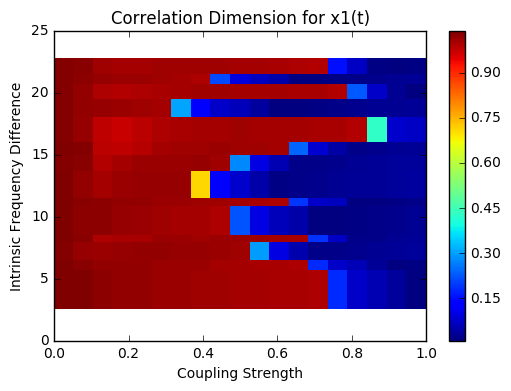

DIM x2


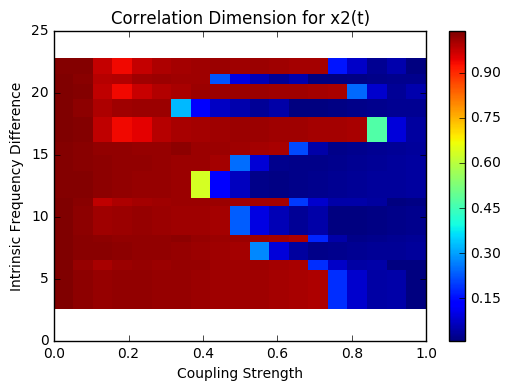

In [34]:
#PLOTTING DIM FOR X1
print("DIM x1")
x=c_list
y=perc_diff_list
z=np.array(dim_x1)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.title("Correlation Dimension for x1(t)")
plt.xlabel('Coupling Strength')
plt.ylabel('Intrinsic Frequency Difference')
plt.colorbar()

plt.show()

#PLOTTING LYAP FOR X2
print("DIM x2")

x=c_list
y=perc_diff_list
z=np.array(dim_x2)

x=np.unique(x)
y=np.unique(y)
X,Y = np.meshgrid(x,y)

Z= z.reshape(len(y),len(x))

plt.pcolormesh(X,Y,Z)
plt.title("Correlation Dimension for x2(t)")
plt.xlabel('Coupling Strength')
plt.ylabel('Intrinsic Frequency Difference')
plt.colorbar()

plt.show()